训练集大小: 797, 测试集大小: 342
测试集中高二元变量分布: (342, 43) (342, 1)
Counter({0: 279, 1: 63})
训练集中高二元变量分布: (797, 43) (797, 1)
Counter({0: 600, 1: 197})
开始训练LightGBM模型。。。
[LightGBM] [Info] Number of positive: 197, number of negative: 600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 797, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247177 -> initscore=-1.113726
[LightGBM] [Info] Start training from score -1.113726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


特征重要性:
[ 65  82   9  88  34 139 165  28 106  73  48   4  54   6  72  50 103  65
  58  62 114  48  20  38   0  13  56  32   0  96 134  76  67  72  86  67
  70  89 113  78  88  74 228]
排列索引:
[42 20 35 22 16 30  5 34  7 19 17 41 21 40 15 32  8 36 10 23  4 33 25  2
 38  3  1 12 31  9  6 13 11 14 28 24 37  0 26 39 18 29 27]
SHAP值:
[[ 0.06017177  0.08780325 -0.01936876 ... -0.12400899  0.18447697
   1.2477995 ]
 [-0.04161112 -0.25106761 -0.02093405 ...  0.00854227 -0.13873633
  -0.15853648]
 [-0.10397389 -0.13766211 -0.03491733 ... -0.18362948 -0.01259753
  -0.08530262]
 ...
 [ 0.05984664  0.0273655   0.02532607 ...  0.02103675  0.01125583
   0.70073712]
 [-0.12400875  0.03056003 -0.00745569 ...  0.30489342  0.04173776
  -0.35099516]
 [ 0.00127893  0.17535111 -0.01359067 ... -0.2410508   0.13628622
  -0.15758734]]
重要特征:
['sleepd_hours' 'commute' 'GAD' 'SE' 'rised' 'PRO' 'TE' 'sleep_min'
 'sleepd_min' 'grade']
重要特征索引:
[27 29 18 39 26  0 37 24 28 14]
Accuracy: 0.7778, Precision: 0.3673, Recall

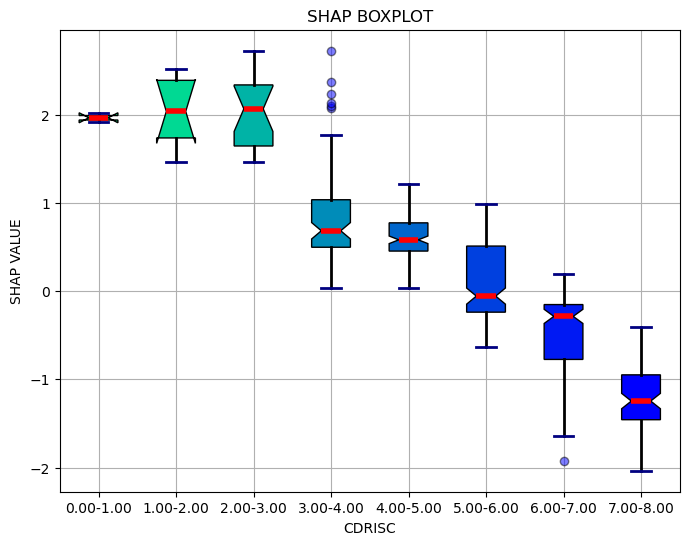

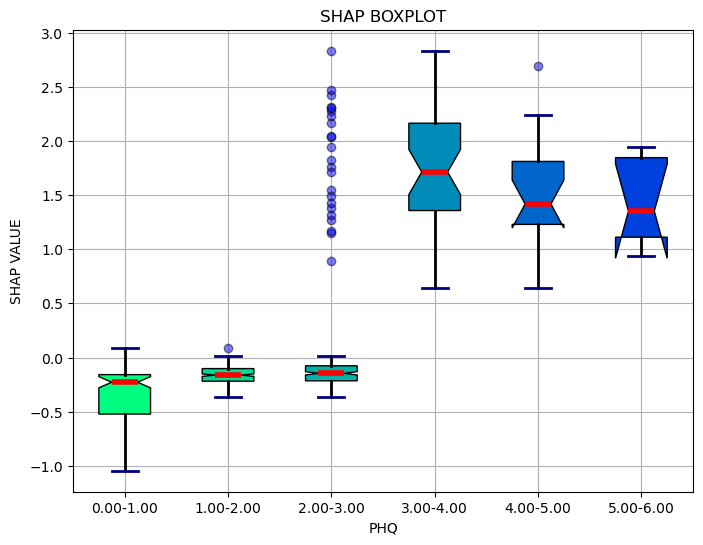

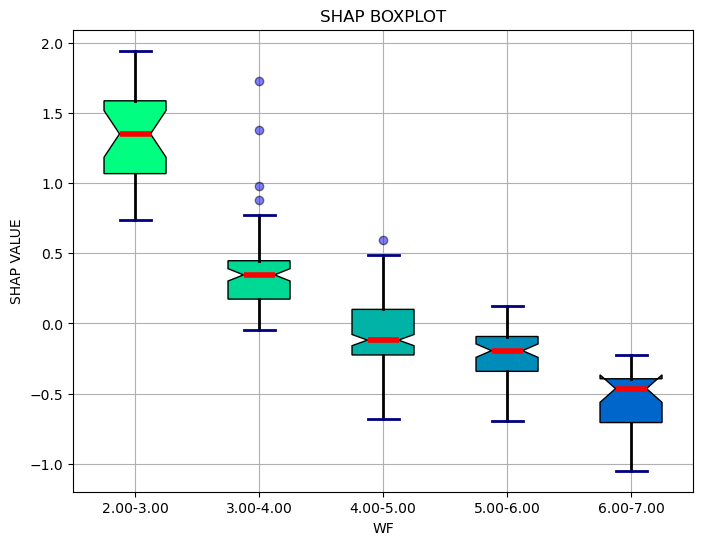

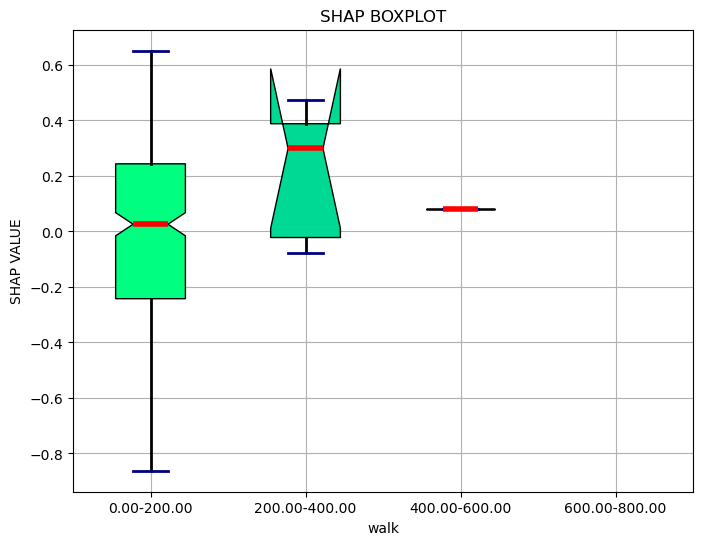

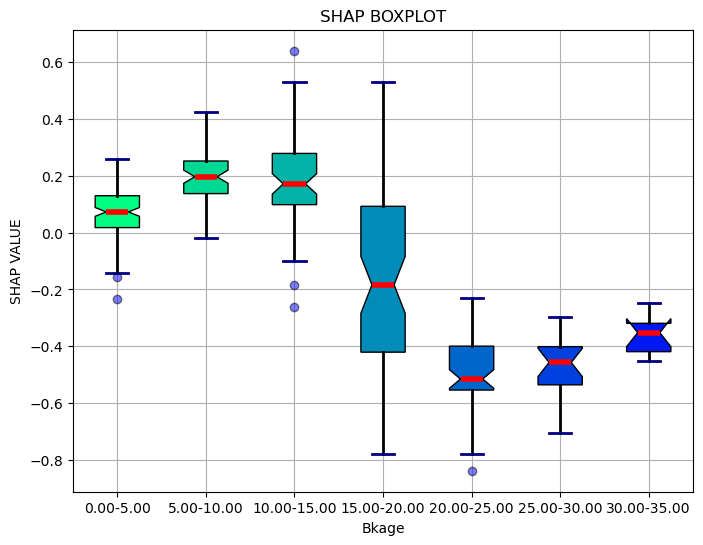

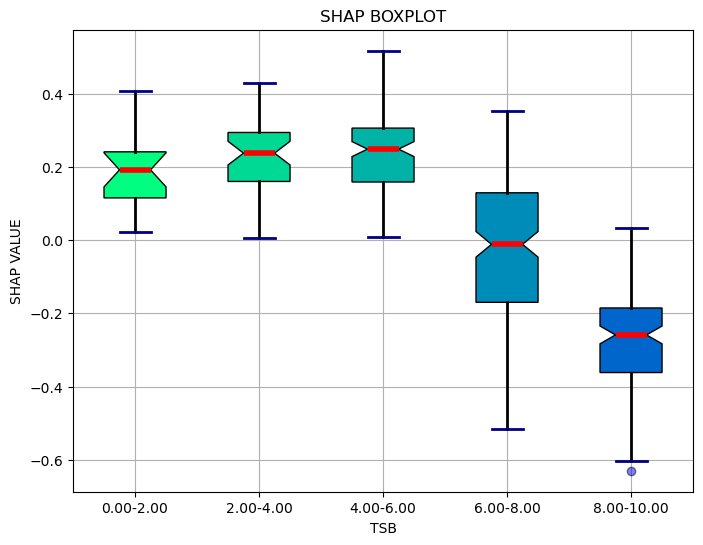

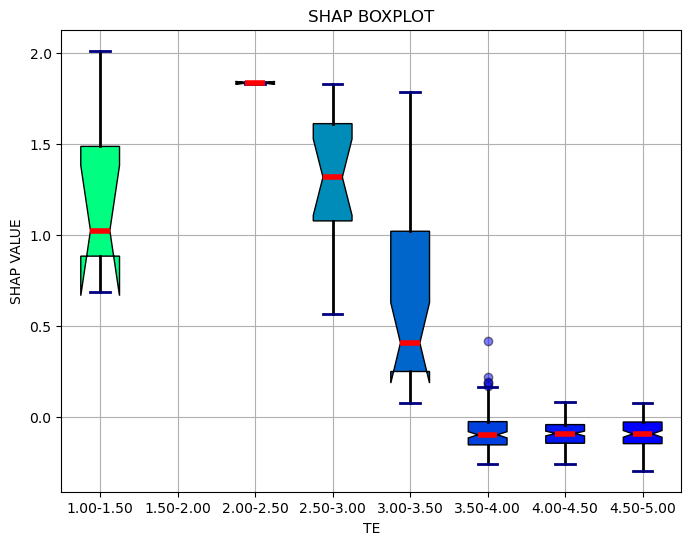

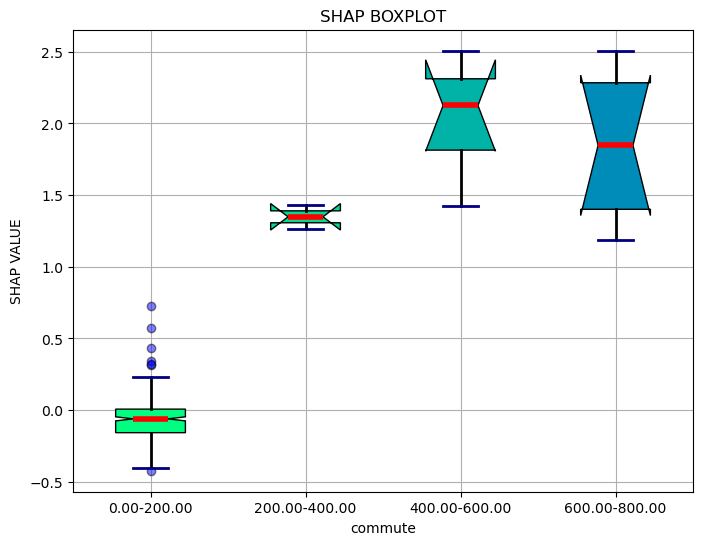

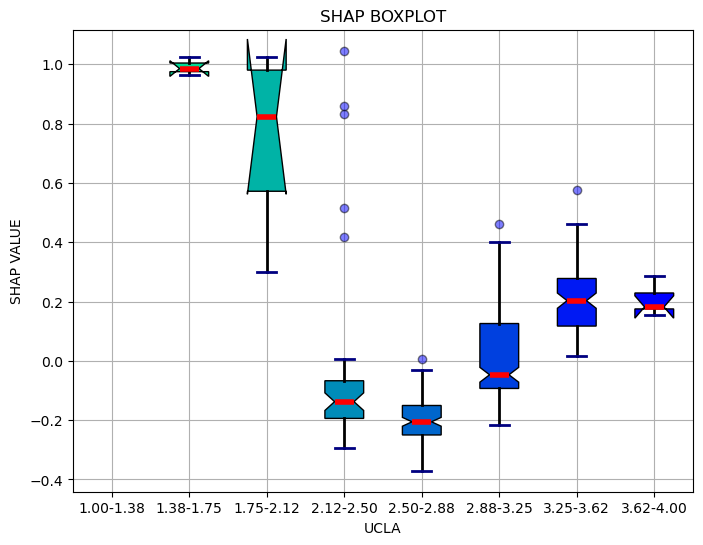

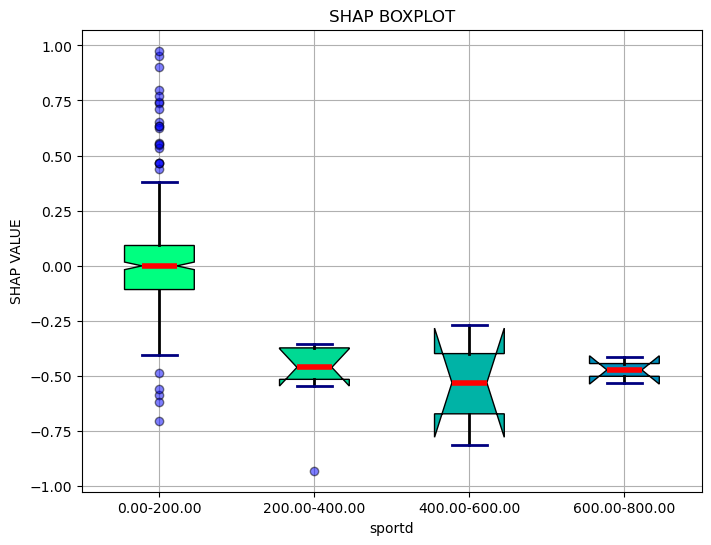

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import matplotlib.cm as cm  # 用于设置颜色映射
from matplotlib.colors import LinearSegmentedColormap  # 添加这一行

# 计算性能指标
def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1score:.4f}")
    return accuracy, precision, recall, f1score

# 模型训练与预测
def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

# 获取特征重要性
def get_feature_importance(model, x_test, y_test, top_n):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    feature_importances = model.feature_importances_
    feature_names = np.array(list(x_test.columns))
    top_features = feature_names[perm_sorted_idx][-top_n:][::-1]
    top_indices = perm_sorted_idx[-top_n:][::-1]
    return feature_importances, perm_sorted_idx, shap_values, top_features, top_indices

# 机器学习函数
def machine_learning(df_src, df_tgt, top_n, split_ratio=0.3, random_seed=28):
    xstd = df_src.std()
    xmean = df_src.mean()
    x_normalized = (df_src - xmean) / xstd

    x_train, x_test, y_train, y_test = train_test_split(x_normalized, df_tgt, test_size=split_ratio,
                                                        random_state=random_seed, shuffle=True)

    xtestvalue = x_test * xstd + xmean

    print(f"训练集大小: {len(x_train)}, 测试集大小: {len(x_test)}")
    print('测试集中高二元变量分布:', x_test.shape, y_test.shape)
    print(Counter(y_test['low_binary']))
    print('训练集中高二元变量分布:', x_train.shape, y_train.shape)
    print(Counter(y_train['low_binary']))

    result_map = {}

    print("开始训练LightGBM模型。。。")
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)

    dt_feature_importance, permsortedidx, shap_values, top_features, top_indices = get_feature_importance(gbm, x_test, y_test, top_n)
    print('特征重要性:')
    print(dt_feature_importance)
    print('排列索引:')
    print(permsortedidx)
    print('SHAP值:')
    print(shap_values)
    print('重要特征:')
    print(top_features)
    print('重要特征索引:')
    print(top_indices)

    result_map['LightGBM'] = (
    top_features, top_indices, xstd, xmean, xtestvalue, shap_values, x_test, y_test, gbm.predict_proba(x_test)[:, 1])

    calc_metrics(y_test, y_predict_test)

    return result_map

# 导入数据
df_path = r"C:\Users\29688\Desktop\T1_T2.xlsx"
save_folder = r"C:\Users\29688\Desktop\study_4\pictures\low"  # 替换为你的保存路径
df = pd.read_excel(df_path)
top_n = 10

# 自变量
df_src = df[['PRO', 'CITY', 'gender', 'age', 'minzu', 'height', 'weight', 'kid', 'Bkage',
             'Lkage', 'Kage', 'education', 'xueduan', 'BZR', 'grade',
             'title', 'Tage', 'PHQ', 'GAD', 'UCLA', 'CDRISC', 'sleep', 'rise', 'sleep_duration',
             'sleep_min', 'sleepd', 'rised', 'sleepd_hours', 'sleepd_min', 'commute', 'work', 'mediation', 'mediationd',
             'sport', 'walk', 'sportd', 'walkd', 'TE', 'subject', 'SE', 'TSB', 'EC', 'WF'
            ]].astype(float)


# 因变量是 SWLS 列
df_tgt = df[['low_binary']]

# 运行机器学习并获取结果
result_map = machine_learning(df_src, df_tgt, top_n)

# 获取 SHAP 值
shap_values = result_map['LightGBM'][5]
x_test_value = result_map['LightGBM'][4]

# 需要绘制箱线图的特征和对应的边界
x_boundaries = {
    'CDRISC': np.linspace(0,8,9),
    'PHQ': np.linspace(0,6,7),
    'WF': np.linspace(2,7,6),
    'walk': np.linspace(0,800,5),
    'Bkage': np.linspace(0,35,8),
    'TSB': np.linspace(0,10,6),
    'TE': np.linspace(1,5,9),
    'commute': np.linspace(0,800,5),
    'UCLA': np.linspace(1,4,9),
    'sportd': np.linspace(0,800,5)
  
    
    
}

# 绘制SHAP值的箱线图，应用第一种代码的颜色和样式
for feature_name in x_boundaries.keys():
    feature_idx = np.where(np.array(df_src.columns) == feature_name)[0][0]
    features_shap = shap_values[:, feature_idx]    # 获取当前特征的 SHAP 值

    features_x_data = x_test_value[feature_name]  # 获取当前特征的测试数据
    features_boundaries = x_boundaries[feature_name]  # 获取当前特征的边界值

    if len(np.unique(features_x_data)) == 2:
        # 如果特征的取值只有两种，单独处理
        shap_values_0 = [features_shap[k] for k, sample_value in enumerate(features_x_data) if sample_value == 0]
        shap_values_1 = [features_shap[k] for k, sample_value in enumerate(features_x_data) if sample_value == 1]

        # 创建箱线图
        plt.figure(figsize=(8, 6))
        bpt = plt.boxplot([shap_values_0, shap_values_1], labels=['0', '1'], patch_artist=True, notch=True)

        # 添加颜色
        colors = [cm.winter(0.85), cm.winter(0.65)]  # 颜色映射
        for patch, color in zip(bpt['boxes'], colors):
            patch.set_facecolor(color)

        # 设置胡须、箱体、异常值、中位数的样式
        for whisker in bpt['whiskers']:
            whisker.set(color='black', linewidth=2)
        for cap in bpt['caps']:
            cap.set(color='navy', linewidth=2)
        for median in bpt['medians']:
            median.set(color='red', linewidth=4)
        for flier in bpt['fliers']:
            flier.set(markerfacecolor='blue', marker='o', alpha=0.5)

        # X/Y轴标签和网格
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.grid(True)
        plt.title(f'SHAP BOXPLOT')
        file_path = os.path.join(save_folder, feature_name + '_boxplot.png')
        plt.savefig(file_path)

    else:
        # 否则按照区间划分进行处理
        box_data = []
        labels = []
        for j in range(len(features_boundaries) - 1):
            lower_bound = features_boundaries[j]
            upper_bound = features_boundaries[j + 1]
            subset_shap_values = [features_shap[k] for k, sample_value in enumerate(features_x_data)
                                  if lower_bound <= sample_value <= upper_bound]
            box_data.append(subset_shap_values)
            interval_label = f'{lower_bound:.2f}-{upper_bound:.2f}'
            labels.append(interval_label)

        # 创建箱线图
        plt.figure(figsize=(8, 6))
        bpt = plt.boxplot(box_data, labels=labels, patch_artist=True, notch=True)

        # 添加颜色
        num_colors = len(box_data)
        colors = [cm.winter(1 - i * 0.15) for i in range(num_colors)]  # 按数量动态生成颜色
        for patch, color in zip(bpt['boxes'], colors):
            patch.set_facecolor(color)

        # 设置胡须、箱体、异常值、中位数的样式
        for whisker in bpt['whiskers']:
            whisker.set(color='black', linewidth=2)
        for cap in bpt['caps']:
            cap.set(color='navy', linewidth=2)
        for median in bpt['medians']:
            median.set(color='red', linewidth=4)
        for flier in bpt['fliers']:
            flier.set(markerfacecolor='blue', marker='o', alpha=0.5)

        # X/Y轴标签和网格
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.grid(True)
        plt.title(f'SHAP BOXPLOT')
        file_path = os.path.join(save_folder, feature_name + '_boxplot.png')
        plt.savefig(file_path)

plt.show()
